# Restoring strength plots

In [2]:
import numpy as np  # http://www.numpy.org
import matplotlib.pyplot as plt   # http://matplotlib.org
import math as M  # https://docs.python.org/2/library/math.html
from sympy.solvers import solve
from sympy import Symbol
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [3]:
#### Constants #####
L_x = 1000000 #zonal extent [m]
L_y = 2000000 #meridional extent [m]
A = L_x*L_y #surface area of interior [m^2] Note that the interior is probably smaller than this
P = 2*L_x+2*L_y #Perimeter [m]

g = 9.81 #gravitational acceleration [m/s^2]
C_p = 3994 #specific heat capacity of sea water [J/(kg K)] source: Steffie's paper
alpha_T = 0.2 #thermal expansion coefficient [kg m^-3 C^-1] source: Steffie's paper
alpha_S = 0.8 #Haline expansion coefficient [kg m^-3]
c = 0.006 #bottom slope coefficient
s = 0.02 #average bottom slope around the perimeter of the marginal sea
S = 35 #reference salinity [ppt]. Spall [2015]
E = -2e-8 #constant freshwater flux [m/s]
S_1 = 35.2 #from Lambert [g kg^-1]

#### Parameters ####
H = 1000 #sill height [m]
f_0 = 1.2e-4 #Coriolis parameter [s^-1]
Gamma = 20 #Restoring strength [W/(m^2 C)]

L = H/s #width of sloping topography of the boundary current [m]
T_1 = 8.87 #ingoing temperature [Celsius]
T_A = 2.8 #Atmospheric temperature [Celsius]
ro_0 = 1028  #density sea water [kg m^-3]. Range of 7 to 9 degrees of sea water
#h_1 = ... #thickness upper layer [m]

#### functions ####
epsilon = c*P/L #ratio of heat fluxed into interior by eddies compared to heat flux by advection into the basin in the inflowing boundary current [-]
mu = A*Gamma*f_0/(alpha_T*g*C_p*H**2*(T_1-T_A)) #[-]

V = g*H/(2*ro_0*f_0*L)*(alpha_T*(T_1-5)-alpha_S*(S_1-35.04))
print(V)
S_eddy = c*V*(S_1-35)
print(S_eddy)
S_2 = (S_1)+(E*A*S+P*L*E*S)/(V*H*L)
print(S_2)

0.5137208171206201
0.000616464980544753
35.13732004052225


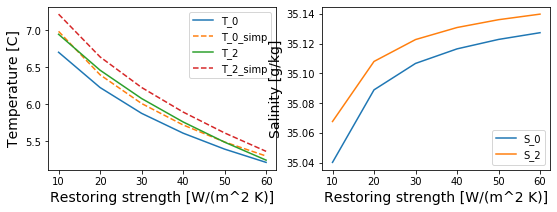

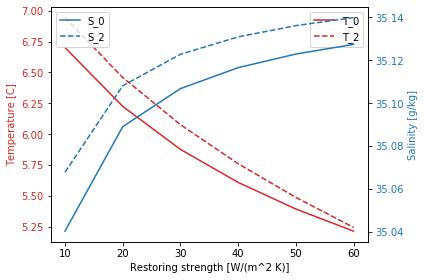

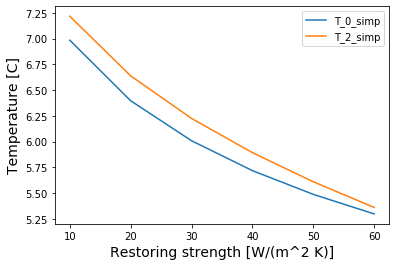

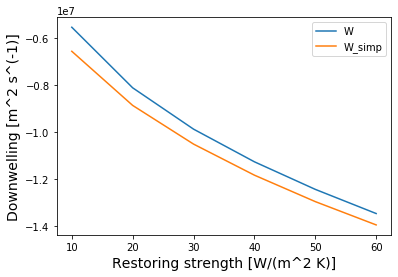

<function matplotlib.pyplot.show(*args, **kw)>

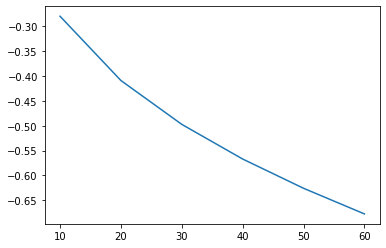

In [10]:
Gamma_array = [10,20,30,40,50,60]

#Salinity model
T_0 = np.zeros(len(Gamma_array))
T_2 = np.zeros(len(Gamma_array))
S_0 = np.zeros(len(Gamma_array))
S_2 = np.zeros(len(Gamma_array))
ro_in_out = np.zeros(len(Gamma_array))
ro_out = np.zeros(len(Gamma_array))
W = np.zeros(len(Gamma_array))


for i in range(len(Gamma_array)):
    Gamma=Gamma_array[i]
    def main(x): # function with seven unkowns:  T_0,  T_2,  S_0,  S_2,  V_1, T_eddy, S_eddy 
                 #                              x[0], x[1], x[2], x[3], x[4],   x[5],   x[6]
        return [P*H*x[5]-A*Gamma*(x[0]-T_A)/(ro_0*C_p),
                P*H*x[6]+A*E*S,
                (T_1-x[1])*x[4]*H*L-(x[0] - T_A + (P*L/A)*(T_1-T_A))*A*Gamma/(ro_0*C_p),
                (S_1-x[3])*x[4]*H*L+E*A*S+P*L*E*S,
                g*H/(2*ro_0*f_0*L)*(alpha_T*(T_1-x[0])-alpha_S*(S_1-x[2]))-x[4],
                c*x[4]*(T_1-x[0])-x[5],
                c*x[4]*(S_1-x[2])-x[6]]
    [T_0[i],T_2[i],S_0[i],S_2[i],V_1,T_eddy,S_eddy] = fsolve(main, [1,1,1,1,1,1,1])
    ro_in_out[i] = (-alpha_T*(T_1-T_2[i]) + alpha_S*(S_1-S_2[i]))
    W[i] = g*H**2*(ro_in_out[i])/(4*ro_0*f_0)

#Simple model
T_0_simp = np.zeros(len(Gamma_array))
T_out_simp = np.zeros(len(Gamma_array))
W_simp = np.zeros(len(Gamma_array))

for i in range(len(Gamma_array)):
    T_0_simp[i] = T_1 - ((A*Gamma_array[i]*f_0/(alpha_T*g*C_p*H**2*(T_1-T_A)))/epsilon)*(M.sqrt(1+2*epsilon/(A*Gamma_array[i]*f_0/(alpha_T*g*C_p*H**2*(T_1-T_A))))-1)*(T_1 - T_A)
    T_out_simp[i] = T_1 - 2*(A*Gamma_array[i]*f_0/(alpha_T*g*C_p*H**2*(T_1-T_A)))*((T_1-T_A)/(T_1-T_0_simp[i])*(1+P*L/A)-1)*(T_1-T_A)
    W_simp[i] = -alpha_T*g*H**2*(T_1-T_0_simp[i])/(4*ro_0*f_0)*(1-(T_out_simp[i]-T_0_simp[i])/(T_1-T_0_simp[i]))

    
plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.plot(Gamma_array, T_0, label='T_0')
plt.plot(Gamma_array, T_0_simp, '--', label='T_0_simp')
plt.plot(Gamma_array, T_2, label='T_2')
plt.plot(Gamma_array, T_out_simp, '--', label='T_2_simp')
plt.xlabel('Restoring strength [W/(m^2 K)]', fontsize=14) # label along x-axes
plt.ylabel('Temperature [C]', fontsize=14) # label along x-axes
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(Gamma_array, S_0, label='S_0')
plt.plot(Gamma_array, S_2, label='S_2')
plt.xlabel('Restoring strength [W/(m^2 K)]', fontsize=14) # label along x-axes
plt.ylabel('Salinity [g/kg]', fontsize=14) # label along x-axes
plt.legend(loc='lower right')
plt.show()

#Two axes plots for salinity model
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Restoring strength [W/(m^2 K)]')
ax1.set_ylabel('Temperature [C]', color=color)
ax1.plot(Gamma_array, T_0, color=color, label='T_0')
ax1.plot(Gamma_array, T_2, '--', color=color, label='T_2')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='best')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Salinity [g/kg]', color=color)  # we already handled the x-label with ax1
ax2.plot(Gamma_array, S_0, color=color, label='S_0')
ax2.plot(Gamma_array, S_2, '--', color=color, label='S_2')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='best')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#Temperature plot simple model
plt.plot(Gamma_array, T_0_simp, label='T_0_simp')
plt.plot(Gamma_array, T_out_simp, label='T_2_simp')
plt.xlabel('Restoring strength [W/(m^2 K)]', fontsize=14) # label along x-axes
plt.ylabel('Temperature [C]', fontsize=14) # label along x-axes
plt.legend(loc='best')
plt.show()

#Downwelling plots
plt.plot(Gamma_array, W, label='W')
plt.plot(Gamma_array, W_simp, label='W_simp')
plt.xlabel('Restoring strength [W/(m^2 K)]', fontsize=14)# label along x-axes
plt.ylabel('Downwelling [m^2 s^(-1)]', fontsize=14) # label along x-axes
plt.legend(loc='best')
plt.show()

plt.plot(Gamma_array, ro_in_out)
plt.show

Something goes wrong in both models for Gamma higher than 60, because then T_2 is lower than T_0. Why could this be? What is the flaw in our model? Temperature decreases as a function of increasing Gamma because the atmospheric forcing is stronger which results in the temperature decreasing faster towards the atmospheric temperature. The salinity increases and seems to go to a constant value. First, it is interesting that the atmospheric heat forcing has an effect on the salinity. But this is ofcourse through the baroclinic velocity which is a function of rho(T,S). For higher Gamma, T_0 decreases, V_1 increases, S_eddy increases and so S_0 increases. The rise of S_2 I don't understand. Because of salt volume flux conservation.

Downwelling increases as a function of increasing restoring strength. For simple model: T_1 remains constant, T_0 and T_2 decreases. Therefore, T_1-T_2 becomes larger and therefore W as well. -(rho1-rho2) = rho_2-rho_1 increases with restoring strenght, which means that rho2 increases. Physically: rho_2 increases, hence the vertical shear should decrease, hence more transport is lost from the boundary current, which results in more downwelling.